In [ ]:
import kagglehub
import pandas as pd
import os

# Step 1: Download the full dataset folder
dataset_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Dataset downloaded to:", dataset_path)

# Step 2: Build full path to metadata CSV
csv_file = os.path.join(dataset_path, "HAM10000_metadata.csv")

# Step 3: Load CSV manually with pandas
df = pd.read_csv(csv_file)

# Step 4: Preview
print("First 5 rows:\n", df.head())





Dataset downloaded to: /kaggle/input/skin-cancer-mnist-ham10000
First 5 rows:
      lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


['ISIC_0028933.jpg', 'ISIC_0028394.jpg', 'ISIC_0027799.jpg', 'ISIC_0028100.jpg', 'ISIC_0027960.jpg']


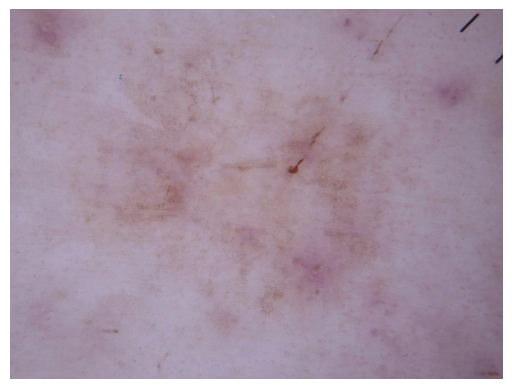

In [ ]:
# image_folder = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
# image_files = os.listdir(image_folder)

# # See the first 5 image filenames
# print(image_files[:5])

# from PIL import Image
# import matplotlib.pyplot as plt

# # Choose one image to display
# img_path = os.path.join(image_folder, image_files[3])
# img = Image.open(img_path)

# # Show image
# plt.imshow(img)
# plt.axis('off')
# plt.show()
#idk why this was giving an error guys T_T i tried a fix??? please tell me if it's causing any issues -A

image_folder = os.path.join(dataset_path, 'HAM10000_images_part_1') #only real change
image_files = os.listdir(image_folder)

# See the first 5 image filenames
print(image_files[:5])

from PIL import Image
import matplotlib.pyplot as plt

# Choose one image to display
img_path = os.path.join(image_folder, image_files[3])
img = Image.open(img_path)

# Show image
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomVerticalFlip()
])

dataset=datasets.ImageFolder(root=dataset_path, transform=transform)
dataload=DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
#SORTS THE CLASSES IN THEIR RESPECTIVE FOLDERS IN WORKING HAM10000
import matplotlib.pyplot as plt
import numpy as np

import os
import shutil
import pandas as pd

# Load metadata
#NOTE: Changed what's now "df" from previous name "metadata" since I assume that was an old title that wasn't consistent with the rest of the code?? wasn't running earlier on my end. Again, correct me if i'm wrong -A
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# Source directory (read-only)
image_src_dirs = [
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/'
]

# Target directory (writable)
output_dir = '/kaggle/working/HAM10000_images_by_class/'

# Create output folders
for label in df['dx'].unique():
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

# Move images into class folders
for i, row in df.iterrows():
    image_id = row['image_id']
    label = row['dx']
    image_filename = image_id + '.jpg'

    # Look for image in both source parts
    found = False
    for src_dir in image_src_dirs:
        src_path = os.path.join(src_dir, image_filename)
        if os.path.exists(src_path):
            dst_path = os.path.join(output_dir, label, image_filename)
            shutil.copy2(src_path, dst_path)
            found = True
            break


In [ ]:
#SPLIT THE DATASET INTO TRAIN, VAL, TEST
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices


def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    target_classes=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    # Get the list of indices to sample from
    trainset=datasets.ImageFolder(root='/kaggle/working/HAM10000_images_by_class/', transform=transform)
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    print("Total relevant indices:", len(relevant_indices))

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    total = len(relevant_indices)
    train = int(0.7 * total)
    val = int(0.15 * total)
    test = total - train - val
    split = [train, val, test]

    # split into training and validation indices
    relevant_train_indices = relevant_indices[:split[0]]
    relevant_val_indices = relevant_indices[split[0]:split[0]+split[1]]
    relevant_test_indices = relevant_indices[split[0]+split[1]:]


    train_sampler = SubsetRandomSampler(relevant_train_indices)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    test_sampler = SubsetRandomSampler(relevant_test_indices)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=test_sampler)
    print("train: "+str(len(train_loader.sampler)))
    print("val: "+str(len(val_loader.sampler)))
    print("test: "+str(len(test_loader.sampler)))

    return train_loader, val_loader, test_loader, classes

target_labels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
train_loader, val_loader, test_loader, classes = get_data_loader(target_labels, 32)




Total relevant indices: 10015
train: 7010
val: 1502
test: 1503


In [ ]:
train_dataset=train_loader.dataset
val_data=val_loader.dataset
print('Num training images: ', len(train_loader.sampler))
print('Num validation images: ', len(val_loader.sampler))
print('Num test images: ', len(test_loader.sampler))

Num training images:  7010
Num validation images:  1502
Num test images:  1503


Distribution of classes in the training set:
{'akiec': np.int64(239), 'bcc': np.int64(351), 'bkl': np.int64(758), 'df': np.int64(78), 'mel': np.int64(774), 'nv': np.int64(4705), 'vasc': np.int64(105)}


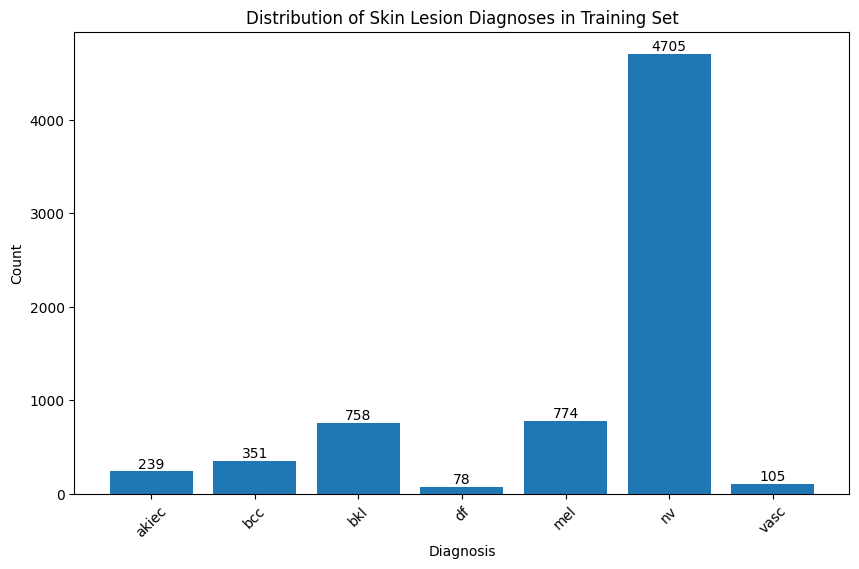

In [ ]:
#PLOTTING DATA DISTRIBUTION
#import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the dataset from the train_loader
train_dataset = train_loader.dataset

indices= list(train_loader.sampler)
# Extract the labels from the dataset
labels = [train_dataset[i][1] for i in indices]

# Get the class names
class_names = train_dataset.classes

# Count the occurrences of each class
label_counts = np.bincount(labels, minlength=len(class_names)) # ensure all classes are included even if count is 0

# Create a dictionary mapping class names to counts
class_distribution = dict(zip(class_names, label_counts))

print("Distribution of classes in the training set:")
print(class_distribution)

# Plot the distribution using matplotlib.pyplot.bar
plt.figure(figsize=(10, 6))
bars = plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Distribution of Skin Lesion Diagnoses in Training Set')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add count labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.show()


In [ ]:
#BASELINE MODEL
import numpy as np
import pandas as pd
import os
from os.path import basename
from PIL import Image
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

#parameters
image_dir = "/kaggle/working/HAM10000_images_by_class"
csv_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
target_labels = ['mel', 'akiec', 'bcc', 'nv', 'bkl',   'df', 'vasc']
image_size = (128, 128)

def load_metadata(csv_path, target_labels):
    df = pd.read_csv(csv_path)
    df = df[df['dx'].isin(target_labels)].copy()
    df['label'] = df['dx'].map({'mel': 1, 'akiec':1,'bcc':1, 'nv': 0, 'bkl':0, 'df':0,'vasc':0})
    return df.reset_index(drop=True)

metadata = load_metadata(csv_path, target_labels)
metadata = pd.DataFrame(metadata)

#make a copy of metadata (aka df) to sort into malignant and benign dataframes
malignant_df = metadata[metadata['label'] == 1].copy()
benign_df = metadata[metadata['label'] == 0].copy()

print(malignant_df['dx'].value_counts())
print(benign_df['dx'].value_counts())

# update image_path to include the class subdirectory
malignant_df['image_path'] = malignant_df.apply(lambda row: os.path.join(image_dir, row['dx'], row['image_id'] + '.jpg'), axis=1)
benign_df['image_path'] = benign_df.apply(lambda row: os.path.join(image_dir, row['dx'], row['image_id'] + '.jpg'), axis=1)


# update available_images, check to reflect the new image_path format
malignant_df = malignant_df[malignant_df['image_path'].apply(lambda x: os.path.exists(x))]
benign_df = benign_df[benign_df['image_path'].apply(lambda x: os.path.exists(x))]

malignant_images = [Image.open(path).resize(image_size) for path in malignant_df['image_path']]
benign_images = [Image.open(path).resize(image_size) for path in benign_df['image_path']]

print(malignant_df.head())
print(malignant_df.columns)

dx
mel      1113
bcc       514
akiec     327
Name: count, dtype: int64
dx
nv      6705
bkl     1099
vasc     142
df       115
Name: count, dtype: int64
        lesion_id      image_id   dx dx_type   age     sex     localization  \
1211  HAM_0000871  ISIC_0025964  mel   histo  40.0  female            chest   
1212  HAM_0000871  ISIC_0030623  mel   histo  40.0  female            chest   
1213  HAM_0000040  ISIC_0027190  mel   histo  80.0    male  upper extremity   
1214  HAM_0005678  ISIC_0031023  mel   histo  60.0    male            chest   
1215  HAM_0005678  ISIC_0028086  mel   histo  60.0    male            chest   

      label                                         image_path  
1211      1  /kaggle/working/HAM10000_images_by_class/mel/I...  
1212      1  /kaggle/working/HAM10000_images_by_class/mel/I...  
1213      1  /kaggle/working/HAM10000_images_by_class/mel/I...  
1214      1  /kaggle/working/HAM10000_images_by_class/mel/I...  
1215      1  /kaggle/working/HAM10000_images_by_

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# combine all images and create labels
all_images = benign_images + malignant_images
labels = [0]*len(benign_images) + [1]*len(malignant_images)

#extracts features from the images
def extract_hog_features(image_list):
    features = []
    for img in image_list:
        gray = rgb2gray(np.array(img))
        hog_feat = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        features.append(hog_feat)
    return np.array(features)

X = extract_hog_features(all_images)
y = np.array(labels)

#splitting the dataset for baseline movel
x_train, x_test, y_train, y_test= train_test_split(X, y, test_size=0.15, random_state=42)

#resampling because of dataset imbalance
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

#train svm model
model=svm.SVC(kernel='rbf', class_weight='balanced', C=10, random_state=42).fit(x_train_resampled, y_train_resampled)
y_predict=model.predict(x_test)

classification_report_str = classification_report(y_test, y_predict)

print("Classification Report: \n", classification_report_str)
print("Accuracy: ", accuracy_score(y_test, y_predict))

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.95      0.88      1202
           1       0.51      0.23      0.32       301

    accuracy                           0.80      1503
   macro avg       0.67      0.59      0.60      1503
weighted avg       0.77      0.80      0.77      1503

Accuracy:  0.801729873586161


In [ ]:
#PRIMARY MODEL
# import torch.nn as nn

# class SkinLesionNet(nn.Module):
#     def __init__(self, num_classes):
#         super(SkinLesionNet, self).__init__()
#         self.features=nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         #TENTATIVE ^, TO BE DECIDED


#     def forward(self, x):
#       x=self.features(x)
#       x=
# commented out because we're not using a custom-made CNN anymore- A

import torch
import torch.nn as nn
import torchvision.models as models

class SkinLesionNet(nn.Module):
    def __init__(self, num_classes=7):
        super(SkinLesionNet, self).__init__()

        # Load ResNet50
        base_model = models.resnet50(pretrained=True)

        # Freeze early layers per report
        for name, param in base_model.named_parameters():
            if name.startswith('conv1') or name.startswith('bn1') or name.startswith('layer1'):
                param.requires_grad = False

        in_features = base_model.fc.in_features
        base_model.fc = nn.Linear(in_features, num_classes)
        self.resnet = base_model

    def forward(self, x):
        return self.resnet(x)

#im so tired... does this look ok?

In [ ]:
#TRAINING LOOPs

def get_model_name(name, batch_size, learning_rate, epoch):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def evaluate(model, loader, criterion, device):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    error = 1.0 - (total_correct / total_samples)

    return error, avg_loss

